# Kickstarter Dataset

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv("./kickstarter-projects/ks-projects-201801.csv")[:1000]

df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## Data Cleaning
    1) I don't care about the project ID's so I'm going to drop that column.
    2) For simplicity, I'm only going to use the usd_pledged_real conversion option for every price measurement, so that I don't have to deal with currency issues. (Dropping columns 'usd pledged', 'pledged', and 'currency'.
    3) I need to fix the launched date so that it matches the deadline (remove time)
    
    

In [9]:

df = df.drop(columns=["ID", "usd pledged", "pledged", "currency", "goal"])
df = df.rename(columns={"usd_pledged_real": "pledged", "usd_goal_real": "goal"})

df['launched'] = df['launched'].apply(lambda x: x.split(' ')[0])

df = df.dropna()
df.head()

,name,category,main_category,deadline,launched,state,backers,country,pledged,goal
0,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-10-09,2015-08-11,failed,0,GB,0.0,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-11-01,2017-09-02,failed,15,US,2421.0,30000.00
2,Where is Hank?,Narrative Film,Film & Video,2013-02-26,2013-01-12,failed,3,US,220.0,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-04-16,2012-03-17,failed,1,US,1.0,5000.00
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,2015-08-29,2015-07-04,canceled,14,US,1283.0,19500.00


## Diving Into The Data
---
### Our main points of focus:
    1) What is the median timeframe for a kickstarter project?
        > Is there a corrolation between success rate and timeframe?
        > Is there a correlation between date launched and timeframe?
     2) Does the goal amount affect a projects success rate?
        > Compare the average goal amounts of projects that failed vs succeeded
     3) What was the most successful general category?

## What is the median timeframe for a kickstarter project?
---
#### Answer: 30 days.

In [10]:
from datetime import date
def date_difference_days(row):
    split_components = lambda d: list(map(int, d.split('-')))
    
    d1, d2 = split_components(row.launched), split_components(row.deadline)
    launched = date(d1[0], d1[1], d1[2])
    deadline = date(d2[0], d2[1], d2[2])

    return (deadline - launched).days

df['days'] = df.apply(date_difference_days, axis=1)

# Remove outliers:
df = df[np.abs(df.days-df.days.mean()) <= 3*df.days.std()]
df.days.median()

30.0

## Is there a corrolation between timeframe and success rate?
---
#### In all likelihood, we can't assume that timeframe is corrolated with success rate. But we do see from the graph below that projects that last longer than 60 days rarely recieve pledges. Maybe they're too ambicious/over-scoped?

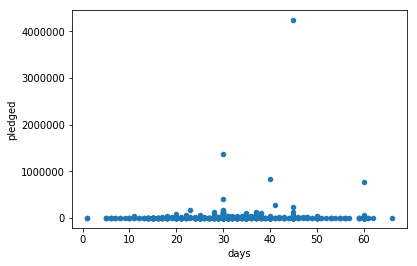

In [11]:
plot = df.plot.scatter(x="days", y="pledged")

# Is there a corrolation between date started/deadline date and success rate?
---
#### Campaigns that began in September and ended in November has significantly more money pledged than any other time period.

In [12]:
# Add helper columns
split_components = lambda d: list(map(int, d.split('-')))
def getEndMonth(row):
    return split_components(row.deadline)[1]
def getStartMonth(row):
    return split_components(row.launched)[1]

df['start_month'] = df.apply(getStartMonth, axis=1)
df['end_month'] = df.apply(getEndMonth, axis=1)

In [13]:
df.groupby("start_month")["pledged"].sum()

start_month
1     1129256.89
2     1564900.43
3      352998.64
4      595306.55
5     1759111.77
6      451140.45
7      559528.60
8      351439.25
9     5133252.76
10     362633.75
11    2276980.72
12     320260.41
Name: pledged, dtype: float64

In [14]:
df.groupby("end_month")["pledged"].sum()

end_month
1      343873.92
2      289372.11
3     1540720.43
4     1220546.04
5      805677.68
6     1239384.09
7      721199.98
8      664535.72
9      302827.21
10     856397.71
11    4622039.73
12    2250235.60
Name: pledged, dtype: float64

## What was the most successful category?

In [33]:
def getSuccessRatios():
    sliced = df.groupby('main_category')['state'].value_counts()
    categories = {}
    for key, val in sliced.items():
        if key[0] in categories:
            categories[key[0]][key[1]] = val
        else:
            categories[key[0]] = {key[1]: val}
    ratios = {}
    for key,val in categories.items():
        total = val["successful"] + val["failed"]
        ratios[key] = val["successful"] / total
    return ratios

print(getSuccessRatios())

{'Art': 0.4880952380952381, 'Comics': 0.53125, 'Crafts': 0.26666666666666666, 'Dance': 0.6666666666666666, 'Design': 0.4461538461538462, 'Fashion': 0.34615384615384615, 'Film & Video': 0.4121212121212121, 'Food': 0.3793103448275862, 'Games': 0.47058823529411764, 'Journalism': 0.4444444444444444, 'Music': 0.5, 'Photography': 0.41379310344827586, 'Publishing': 0.3076923076923077, 'Technology': 0.39344262295081966, 'Theater': 0.6842105263157895}


In [ ]:
getSuccessRatios()